In [35]:
%matplotlib inline
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from operator import itemgetter
import pandas as pd
import scipy.stats as ss
from bs4 import BeautifulSoup
import urllib2

In [36]:
import matplotlib
matplotlib.rcParams.update({
  "lines.linewidth": 2.0,
  #"examples.download": True,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.color_cycle": ["#348ABD", "#A60628", "#7A68A6", "#467821", "#CF4457", "#188487", "#E24A33"],
  "axes.facecolor": "#eeeeee",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.embed_char_paths": "path",
  "examples.directory": ""
})

In [37]:
#get list of positive words
req = urllib2.Request("https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/blob/master/data/opinion-lexicon-English/positive-words.txt")
try:
    html = urllib2.urlopen(req).read()
    raw = BeautifulSoup(html,"html.parser").get_text()
    posWords = raw.split("\n")
    del(posWords[:posWords.index("a+")])
    posWords = set(posWords)
except urllib2.HTTPError, http_e:
    pass

In [38]:
#get list of negative words
req = urllib2.Request("https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/blob/master/data/opinion-lexicon-English/negative-words.txt")
try:
    html = urllib2.urlopen(req).read()
    raw = BeautifulSoup(html,"html.parser").get_text()
    negWords = raw.split("\n")
    del(negWords[:negWords.index("2-faced")])
    negWords = set(negWords)
except urllib2.HTTPError, http_e:
    pass

In [39]:
#input json files
business_file_path = "C:\\TempDrive\\MS\\Fall16\\DataScience\\Assignment3\\data\\yelp_dataset_challenge_academic_dataset\\yelp_academic_dataset_business.json"
review_file_path = 'C:\\TempDrive\\MS\\Fall16\\DataScience\\Assignment3\\data\\yelp_dataset_challenge_academic_dataset\\yelp_academic_dataset_review.json'
tip_file_path = 'C:\\TempDrive\\MS\\Fall16\\DataScience\\Assignment3\\data\\yelp_dataset_challenge_academic_dataset\\yelp_academic_dataset_tip.json'

In [40]:
businessDict ={}
usersDict = {}
idToIndex = {}
indexToId = {}
count = 0
#read the review json and initialize data structures needed for review network
with open(review_file_path) as review_file:    
    for line in review_file:
        data = json.loads(line)
        try:
            businessDict[data["business_id"]].add(data["user_id"])
        except KeyError:
            businessDict[data["business_id"]] = set()
            businessDict[data["business_id"]].add(data["user_id"])
            sentimentScore = 0
            idToIndex[data["business_id"]] = [count,0, sentimentScore]
            indexToId[count] = (data["business_id"],0)
            count = count+1
            
        #get the sentiment score based on review text
        reviewWords = data["text"].split(" ")  
        sentimentScore = len(posWords.intersection(reviewWords)) - len(negWords.intersection(reviewWords))  
        idToIndex[data["business_id"]][2] += sentimentScore
        try:
            usersDict[data["user_id"]].add(data["business_id"])
        except KeyError:
            usersDict[data["user_id"]] = set()
            usersDict[data["user_id"]].add(data["business_id"])
            idToIndex[data["user_id"]] = (count,1) 
            indexToId[count] = (data["user_id"],1)
            count = count+1

In [41]:
#for business and user, construct a dict with degree of a node as key and number of nodes with that degree as value 
networkData_users = {}
networkData_business = {}
for business in list(businessDict.keys()):
    try:
        networkData_business[len(businessDict[business])] += 1
    except KeyError:
        networkData_business[len(businessDict[business])] = 1
        
for user in list(usersDict.keys()):
    try:
        networkData_users[len(usersDict[user])] += 1
    except KeyError:
        networkData_users[len(usersDict[user])] = 1      

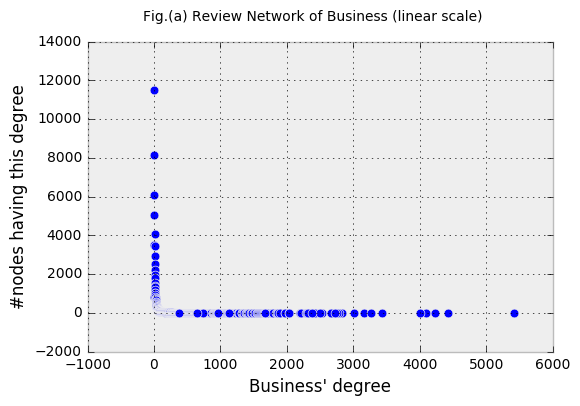

In [42]:
#plot business data (linear scale)
x = networkData_business.keys()
y = networkData_business.values()
plt.xlabel("Business' degree")
plt.ylabel("#nodes having this degree")
plt.scatter(x,y, s=40)
plt.suptitle("Fig.(a) Review Network of Business (linear scale)")
plt.show()

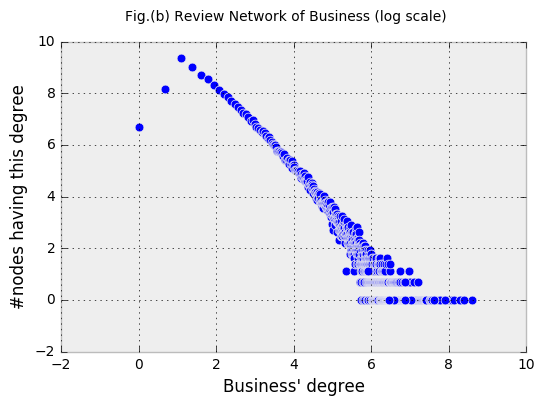

In [43]:
#plot business data (log scale)
plt.xlabel("Business' degree")
plt.ylabel("#nodes having this degree")
plt.scatter(np.log(x), np.log(y), s=40)
plt.suptitle("Fig.(b) Review Network of Business (log scale)")
plt.show()

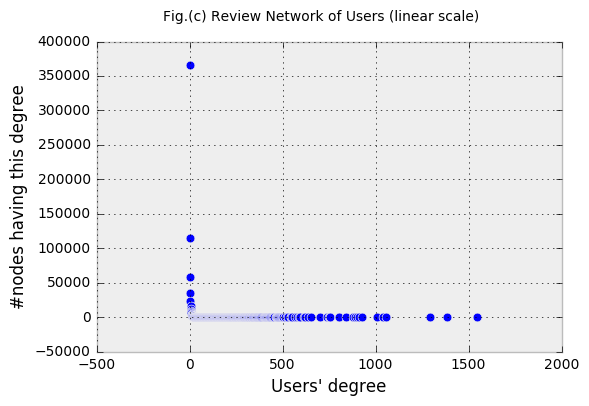

In [44]:
#plot user data (linear scale)
x = networkData_users.keys()
y = networkData_users.values()
plt.xlabel("Users' degree")
plt.ylabel("#nodes having this degree")
plt.scatter(x, y, s=40)
plt.suptitle("Fig.(c) Review Network of Users (linear scale)")
plt.show()

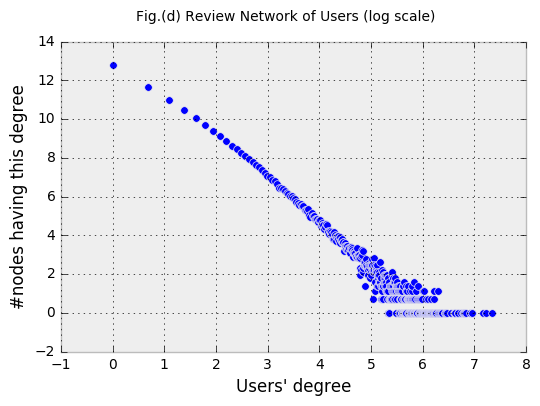

In [45]:
#plot user data (log scale)
plt.xlabel("Users' degree")
plt.ylabel("#nodes having this degree")
plt.scatter(np.log(x), np.log(y), s=30) #more than one logs give runtime warning: divide by zero
plt.suptitle("Fig.(d) Review Network of Users (log scale)")
plt.show()

The above plots show the review network for businessess and users on linear and log scale. We can observe that log scale plot is better than linear scale. In linear scale, there is a lot of overlap of points. So, it is very difficult to say or learn anything about the distribution. Looking at linear scale figures a and c, we might think that there are few outlier poits which lie too far from rest of the points. But, after applying log, in figure b and d, we can see that those points are not really outliers. From the distribution, we can learn that for both user and business network, there are many nodes with less degree, whereas, lesser number of nodes have more degree.

In [46]:
def compute_PageRank(G, beta=0.85, epsilon=10**-4, ranks = None):
    '''
    Efficient computation of the PageRank values using a sparse adjacency 
    matrix and the iterative power method.
    
    Parameters
    ----------
    G : boolean adjacency matrix. np.bool8
        If the element j,i is True, means that there is a link from i to j.
    beta: 1-teleportation probability.
    epsilon: stop condition. Minimum allowed amount of change in the PageRanks
        between iterations.

    Returns
    -------
    output : tuple
        PageRank array normalized top one.
        Number of iterations.

    '''    
    #Test adjacency matrix is OK
    n,_ = G.shape
    assert(G.shape==(n,n))
    #Constants Speed-UP
    deg_out_beta = G.sum(axis=0).T/beta #vector
    #Initialize
    if ranks==None:
        ranks = np.ones((n,1))/n #vector
    time = 0
    flag = True
    while flag:  
        #print 'ranks: ',ranks
        time +=1
        with np.errstate(divide='ignore'): # Ignore division by 0 on ranks/deg_out_beta
            new_ranks = G.dot((ranks/deg_out_beta)) #vector
        #Leaked PageRank
        new_ranks += (1-new_ranks.sum())/n
        #Stop condition
        if np.linalg.norm(ranks-new_ranks,ord=1)<=epsilon:
            flag = False        
        ranks = new_ranks
    return(ranks, time)

In [47]:
#returns sorted ranks for business from a list containing both users and businessess
def getBusinessRanks(pr, allNodes):
    rankList = np.reshape(pr, len(allNodes)).tolist()[0]
    rankIDList = []
    rankBusinessIds = []
    for i  in range(len(allNodes)):
        each = (rankList[i], indexToId[allNodes[i]][0], indexToId[allNodes[i]][1])
        rankIDList.append(each)
    for each in rankIDList:
        if each[2] == 0:
            rankBusinessIds.append(each)
    rankBusinessIds = sorted(rankBusinessIds, key= lambda x: x[0],reverse = True)
    return rankBusinessIds

In [48]:
row = []
col = []
allNodes = []
edges = 0
#construct the network matrix, which is represented as sparse matrix
for business in businessDict:
    r = idToIndex[business][0]
    allNodes.append(r)
    
    for user in list(businessDict[business]):
        c = idToIndex[user][0]
        allNodes.append(c)
        row.append(r)
        col.append(c)
        row.append(c)
        col.append(r)
        edges = edges + 2
csr_m = csr_matrix(([True]*edges,(row,col)),shape=(len(allNodes), len(allNodes)))

In [49]:
#compute page rank for the above generated matrix
pr, iters = compute_PageRank(csr_m)
print 'Number of iterations required: ',iters

Number of iterations required:  49


In [50]:
#get ranks of businessess
rankBusinessIds = getBusinessRanks(pr, allNodes)

In [51]:
#generate data(to be written into json) for top 100 restaurants
data = {}
for i in range(100):
    item = {
            "pagerank": rankBusinessIds[i][0], 
            "businessId": rankBusinessIds[i][1]
           }
    data["Top"+str(i)] = item
    
#write output to json file
with open('HW3.json', 'w') as outfile:
    json.dump(data, outfile)

In [61]:
#compute pvalue using permutation test
def doPermutationTest( x, y, coeff ):
    y = np.asarray(y)
    x = np.asarray(x)
    count = 0
    #number of permutations is kept low, otherwise, it takes a lot of time to get results, due to size of data
    nPermutes = 100
    for iterator in range( nPermutes ):
        np.random.shuffle(y)
        result = ss.spearmanr(x,y)
        if abs(result[0]) > abs(coeff):
            count = count + 1
    pval = float(count)/nPermutes
    return pval

In [53]:
#extract number of tips for each business from yelp_academic_dataset_tip.json
businessList = []
tipList = []
with open(tip_file_path) as tip_file:    
    for line in tip_file:
        data = json.loads(line)
        businessList.append(data["business_id"])
        tipList.append(1)
tipData = pd.DataFrame([businessList,tipList]).T
tipData.columns = ["business_id", "#tips"]
tipData = tipData.groupby(by=['business_id'])['#tips'].sum()

In [54]:
##################################################################################################################
#extract following 5 features from data:
# review_count: number of reviews given by user for each restaurant
# sentiment_score: a score determining the number of positive vs negative words used in reviews
# stars: average rating 
# #categories: number of categories which are available at that restaurant (pizza, italian, coffe & tea, etc)
# #tips: the number of tips received by the employee of that restaurant
###################################################################################################################
businessList = []
reviewList = []
stars = []
categoryLen = []
sentimentScores=[]
tipList = []
with open(business_file_path) as business_file:    
    for line in business_file:
        data = json.loads(line)
        businessList.append(data["business_id"])
        reviewList.append(data["review_count"])
        stars.append(data["stars"])
        categoryLen.append(len(data["categories"]))
        try:
            score = idToIndex[data["business_id"]][2]
            sentimentScores.append(score)
        except LookupError:
            sentimentScores.append(0)
        try:
            tipList.append(tipData[data["business_id"]])
        except KeyError:
            tipList.append(0)
restaurantData = pd.DataFrame([businessList,reviewList,sentimentScores,stars,categoryLen, tipList]).T
restaurantData.columns = ["business_id", "review_count","sentiment_score", "stars", "#categories", "#tips"]
print 'Features for ranking restaurants:'
restaurantData[:100]

Features for ranking restaurants:


business_id review_count sentiment_score stars #categories  \
0   5UmKMjUEUNdYWqANhGckJw            7              10   3.5           2   
1   UsFtqoBl7naz8AVUBZMjQQ            5              17     3           1   
2   cE27W9VPgO88Qxe4ol6y_g            5              16   2.5           3   
3   mVHrayjG3uZ_RLHkLj-AMg           26              82   4.5           5   
4   mYSpR_SLPgUVymYOvTQd_Q            3              14     5           2   
5   KayYbHCt-RkbGcPdGOThNg           23              48     4           4   
6   b12U9TFESStdy7CsTtcOeg            9              -2   2.5           3   
7   Sktj1eHQFuVa-M4bgnEh8g            4              -1     4           2   
8   3ZVKmuK2l7uXPE6lXY4Dbg            3               1   2.5           4   
9   QoDa50dc7g62xciFygXB9w            7              11     4           2   
10  1_lU0-eSWJCRvNGk78Zh9Q            4               3   4.5           2   
11  _qopVQ6_Mz6W7-Pmbi56GQ            3              10   3.5           2   
12  wJr6kSA5dchdgOdwH6dZ2w           10              22   3.5           4   
13  yXuao0pFz1AxB21vJjDf5w            5               2     4           2   
14  LLJMI-_fSp6OYQuY4rwarw            3               3   3.5           2   
15  F04xyOUA2xnUoCiWpx9iJA            3               7     3           3   
16  Cdcus0NADzyY3XiJM2O5Sg            4               8     3           2   
17  fNGIbpazjTRdXgwRY_NIXA           10              21     4           5   
18  b9WZJp5L1RZr4F1nxclOoQ           69             156   4.5           3   
19  zaXDakTd3RXyOa7sMrUE1g            9              17     4           2   
20  zgy27FSnvwdINfk5cXBIyQ           11              20   3.5           3   
21  WETE_LykpcnrC1sFcQ5EGg            8              12   3.5           5   
22  6o3RK6rTcN3nw-j-r2nQmA            4               0   2.5           2   
23  woOVJ0Z2f6XNCDntHA3b_g           10              29   4.5           2   
24  rv7CY8G_XibTx82YhuqQRw            6               3     3           1   
25  e_U_FnpdKVgNb4mUN2cU_Q            8              13   2.5           3   
26  SQ0j7bgSTazkVQlF5AnqyQ           10               8   2.5           2   
27  LTXS986DAz-4jE_sV2Ui4w            3               3   3.5           2   
28  wqu7ILomIOPSduRwoWp4AQ           16              17   3.5           4   
29  1u2NauOy8xDj7aFQET680A            8               5     3           4   
..                     ...          ...             ...   ...         ...   
70  LG_Dgv7u7P2ASDWU1RAyWQ            5               8   2.5           2   
71  ISKLP0qxApATxRlUDob6Cg           23              51   3.5           3   
72  DMy5IG-dNrH4ARk96KngEA            8               0     2           4   
73  uLnDFdn011hEroQQMLmxNQ           12              12     4           2   
74  rdATJvFQK4C73NIQ3zoY3w            5               9     4           3   
75  g10zmpUzmMJOOIjj_JJPvg            9              11     3           3   
76  eznh0XjVtv924K-KYx_ilQ           51              98     3           3   
77  LQFWH1AKJlXGmEBlIKsBCw            7              29     4           3   
78  LO2CjrNL8DXkvm9uALgRjQ            9              14     3           2   
79  usSROUMiAgPcxV3Ym0OxMQ          122             272   3.5           3   
80  qfL7ZFkxqDZOPIaVVfT3Aw            7              14   3.5           5   
81  GlYPVYSOVT7zn00Kk_Oz4g           10               0   2.5           4   
82  WaHXyBwljbKNPmmJZn5j8Q            3               3     3           2   
83  bCw9HKDFLU_PppnNg-nIlw            4              16   2.5           2   
84  CL3tZqbYT7B5zgewKCS6-Q            5              -2   1.5           3   
85  u22QDAON1kk0wjoTliyftw            6              19   4.5           2   
86  4ykgzzzGEWjMD5lwk1-l9A           18              83   4.5           3   
87  53Yk2EODWnV9qHQECzeHVQ            6              12   3.5           2   
88  CxkzthqKSwae9-3MK6a_vQ            3               6   4.5           2   
89  iBZRphMDFcS2aMbawc1OvA            3               0     5           2   
90  hnHt6Ei

In [55]:
#calculate spearman correlation between each of the above features and their respective p values
numericalCols = restaurantData.columns[1:]
corrColsCombinations = list(itertools.combinations(numericalCols, 2))
corrDf = pd.DataFrame(columns=['Feature1', 'Feature2', 'CorrelationCoefficient', 'scipystat-pvalue', 'Permutation test p-value'])
print 'Spearman Rank Correlation Results:'
for each in corrColsCombinations:
    a = restaurantData[each[0]]
    b = restaurantData[each[1]]
    result = ss.spearmanr(a, b)
    y = list(b)
    pval = doPermutationTest( a, y, result[0])
    corrDf.loc[len(corrDf)] = [each[0], each[1], result[0], result[1], pval]   
corrDf

Spearman Rank Correlation Results:


Feature1         Feature2  CorrelationCoefficient  scipystat-pvalue  \
0     review_count  sentiment_score                0.788178      0.000000e+00   
1     review_count            stars               -0.029950      1.634983e-18   
2     review_count      #categories                0.133223      0.000000e+00   
3     review_count            #tips                0.716523      0.000000e+00   
4  sentiment_score            stars                0.297087      0.000000e+00   
5  sentiment_score      #categories                0.139580      0.000000e+00   
6  sentiment_score            #tips                0.591591      0.000000e+00   
7            stars      #categories                0.039315      9.650141e-31   
8            stars            #tips               -0.109120     9.204594e-226   
9      #categories            #tips                0.089487     3.237132e-152   

   Permutation test p-value  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  
5                       0.0  
6                       0.0  
7                       0.0  
8                       0.0  
9                       0.0

The above table shows the spearman correlation coefficient, the pvalues returned by scipy.stats.spearmanr function and the pvalues obtained by doing permutation test. We are computing spearman correlation coefficient, so, the relationship between these features need not be linear, it can be monotonic as well. We can see that review_count and sentiment_score have high correlation, which means more number of reviews imply more positive reviews. Also, review_count and #tips have high correlation, which can also mean that the more tips employees of restaurant get, the more is the number of reviews. sentiment_score and #tips also have good correlation between them. Whereas, stars and #tips have negative correlation, which means, the more rating a restaurant have, the less likely they are to receive tips. Similarly, we can infer few such things from above correlation coefficients.

In [56]:
#normalize data
normalisedDF = restaurantData.copy()
normalisedDF[numericalCols] = (restaurantData[numericalCols] - \
                                restaurantData[numericalCols].mean())/ \
                                restaurantData[numericalCols].std()

In [57]:
#aggregate the above 5 features and generate a score for each restaurant
normalisedDF["score"] = 0.20 * normalisedDF["review_count"] + \
                        0.20 * normalisedDF["sentiment_score"] + 0.20 * normalisedDF["stars"] + \
                        0.20 * normalisedDF["#categories"] + 0.20 * normalisedDF["#tips"]
        
normalisedDF['business_rank'] = normalisedDF['score'].rank(ascending=False)
normalisedDF['priors'] = normalisedDF['score'].rank(ascending=True)
sortedOnScore = normalisedDF.sort_values(['business_rank'])
sortedOnScore.business_rank = sortedOnScore.business_rank.astype(np.int64)
print 'Ranking of restaurants, based on aggregated score of 5 features: '
sortedOnScore.head(100)

Ranking of restaurants, based on aggregated score of 5 features: 


business_id review_count sentiment_score     stars  \
20187  4bEjOyTaDG24SY5TxsaUNQ      56.7334         69.2362  0.322551   
17697  jf67Z1pnwElRSXllpQHiJg      24.8593         9.91492 -0.205965   
50493  zt1TpTuJ6y9n551sw9TaEg      45.3879         47.4282 -0.205965   
60454  sIyHTizqAiGu12XMLX3N3g      47.6791         49.9197  0.322551   
27816  2e2e7WgqU1BnpxmQL5jbfw      42.8115         34.8706  0.851067   
43750  AtjsjFzalWqJ7S9DUFQ4bw      29.3864         36.6132  0.322551   
62785  aGbjLWzcrnEx2ZmMCFm3EA       42.195         43.9616  0.322551   
63825  iUPJmJvHy9fVfRxsuwwdLQ      34.3461         29.2981  0.851067   
4246   hW0Ne_HTHEAgGF1rAdmR-g      17.5165         9.20306 -0.205965   
36148  JpHE7yhMS5ehA9e8WG_ETg       28.954         34.3479 -0.205965   
36507  Xhg93cMdemu5pAMkDoEdtQ      34.4749         23.2511 -0.734481   
20204  tFU2Js_nbIZOrnKfYJYBBg      28.5215         37.6217  0.322551   
20349  YNQgak-ZLtYJQxlDwN-qIg      32.3125         32.3828 -0.205965   
20058  lliksv-tglfUz1T3B3vgvA      29.3588         26.2505  0.322551   
46318  PXviRcHR1mqdH4vRc2LEAQ      23.8103         23.9333  0.322551   
50579  eq6lQI039SBLC6sHm3idGA      28.0798           19.41  0.322551   
41238  QbmcCE_cLq4WO8ZMKImaLw      32.5978         20.2702  0.322551   
20172  34uJtlPnKicSaX1V8_tu1A      23.9023         24.2781  0.322551   
20239  CZjcFdvJhksq9dy58NVEzw       30.095         24.4375 -0.205965   
20179  eWPFXL1Bmu1ImtIa2Rqliw      25.3838         20.6558 -0.734481   
35573  Es300Ys1XXPYg8aI7BKVYQ       25.393         22.2834  0.322551   
20067  DO3Gk17RyJVW7zYMCtYPnw      24.0035         30.3289  0.322551   
20165  -7yF42k0CcJhtPw51oaOqQ      20.5714         21.9831  0.322551   
20798  xfwRO04KbAPw_zRotCfWQQ      25.9727         15.7469  0.322551   
20194  6LM_Klmp3hOP0JmsMCKRqQ      26.6812         14.4011    -1.263   
9095   FV16IeXJp2W6pnghTz2FAw      19.3936         11.4239 -0.205965   
50407  BqrTtox0JbG-P_DKBB5bBw      21.4179         21.2824  0.322551   
57276  mDdqifuTrfXAOfxiLMGu5Q      22.1448         30.8479  0.322551   
28002  5paMI5Hhciyl09yGpzdoJw      17.5349         22.2649  0.322551   
47131  DjOxXobyGDwWt89q4z1twg      16.7619         15.3539  0.322551   
...                       ...          ...             ...       ...   
60385  ZP6qFq7LUh6Tr7WHPoOW6g      13.5874         14.1638  0.322551   
27292  QnAzW6KMSciUcuJ20oI3Bw      12.2716         12.4361  0.322551   
20431  rBPQuQgTcMtUq5-RYhY2uQ      16.1362         13.6855 -0.205965   
9242   4UVhuOLaMm2-34SrW8y-ag      11.6919         11.5796  0.322551   
62515  A3Jv-FFRsDEWXxKJ6ZIxfg      16.9368          13.756 -0.734481   
20324  V1nEpIRmEa1768oj_tuxeQ      12.8605         15.5986  0.851067   
27194  YrIfgzLj0DPStJ1ESAS_Qg        12.52         10.8974  0.322551   
18060  8IMEf_cj8KyTQojhNOyoPg      14.1763         8.41705 -0.734481   
77808  QhwkFogGQA-Ar176Ul5PUQ      16.4123         13.5595  0.322551   
50839  MuIXnv7Oq7X3-4aEsp9dDA      11.8667         15.1574  0.851067   
28841  j_pce4pG9krrBeYwUni8Pg      9.17988         9.53674  0.322551   
21149  WNy1uzcmm_UHmTyR--o5IA      12.1428         11.3127  0.851067   
20325  EWMwV5V9BxNs_U6nNVMeqw      9.74118         12.8142  0.322551   
72851  ateowLnq6kpgNNWHzCDByQ      16.3755         11.9541 -0.205965   
48599  _CHH9KN1bO5cs_GHjQ-r1A      8.83023         10.4266  0.322551   
27108  eP9T-2a94ChFAl1Rd2R0jg      12.8237         14.9683  0.322551   
69270  OwBPjUz2o0J5K3DzcHkBtg      9.82399         14.4567  0.851067   
17779  OUpcKYGbVYgSS1Oo7aQ56Q      12.5568         9.99648 -0.205965   
25202  1fjgZaW6_qTYoAaSCfI-VQ      9.82399         8.59502 -0.205965   
66921  MN0OLvP8i0SirMJ7AMuMzA      12.1796         12.5881  0.322551   
27914  3f-RP2-EE94eifGnepUBpg      14.8388         14.6866  0.851067   
34244  YKOvlBNkF4KpUP9q7x862w      11.8851         14.1082  0.322551   
20205  KjymOs12Mpy0Kd54b7T9MA      13.3022         15.3502  0.322551   
39433  BqD7X5CHXnJ14YbBBlLx1w      12.4464         14.8757

In [58]:
#get prior ranks for businessess from above scoring function and assign unique rank for all the users
#and normalise the ranks so that their sum equals 1
businessScores=sortedOnScore[["business_id", "priors"]]
businessScores=businessScores.set_index('business_id')['priors'].to_dict()
ranks = []
for node in allNodes:
    nodeVal = indexToId[node]
    if nodeVal[1]:
        ranks.append(1)
    else:
        ranks.append(businessScores[nodeVal[0]])
sum_r = sum(ranks)
normalisedRanks = [x/float(sum_r) for x in ranks]
normalisedRanks = np.asarray(normalisedRanks)
normalisedRanks = normalisedRanks.reshape(len(normalisedRanks),1)

In [59]:
#compute page rank with prior ranks
pr_prior, iters_prior = compute_PageRank(csr_m, ranks=normalisedRanks)
print 'Number of iterations required by using score as priors: ',iters_prior

C:\Users\Pooja Sonawane\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


Number of iterations required by using score as priors:  48


Below given are the top 100 restaurants based on pagerank computed after giving the initial priors. We can see that there is no change in the ranks and the order of restaurants. This won't change, because we are running pagerank on the same network. So, the final pageranks would be same as before. The only difference is that we won't be starting from ranks with equal priority. By assigning priors, we can skip some iterations, and save some time. We can see that, without priors, the algorithm had taken 49 iterations to converge, wheras, with priors, it took 48 iterations.

In [60]:
#display ranks of top 100 businesses
rankBusinessIds_prior = getBusinessRanks(pr_prior, allNodes)
print 'PageRank(computed with priors) of top100 restaurants: '
rankBusinessIds_prior[:100]

PageRank(computed with priors) of top100 restaurants: 


[(0.00021417781202938538, u'16TYrZFb2OraLI1LYDx0gw', 0),
 (0.00017247716739521171, u'k7ToRC0nf8WFABwPX2ZWPg', 0),
 (0.0001582087897893228, u'9tAbTDdYTASHL7EU1e-OWw', 0),
 (0.00014014827325014112, u'LHyB122HpkWueoWj-0bX4A', 0),
 (0.00012922523691340885, u'ukmUw9Lk6JjS6cndXlCj1A', 0),
 (0.00012716274219070985, u'_G6jx1ZjsAQHxCZjOvQfHg', 0),
 (0.00012626025364034378, u'rjsWgfJ0YUR0yySZQYVvwA', 0),
 (0.00012135948930483064, u'ODRKHH5DS1ymFGP7GvJGXA', 0),
 (0.0001142224676977046, u'cxUgrIta4iCiKgiqdN-MMw', 0),
 (0.0001076513241489331, u'b-IWZuVd3f0GcbtetwG5WA', 0),
 (9.534077351502821e-05, u'1uhipArheEVbwWyoAbKAGg', 0),
 (9.431645948568951e-05, u'8aXm2jhtITo2eCWBzz7Txg', 0),
 (8.757938904787587e-05, u'icuiO4JyU14EPaqyBut2DQ', 0),
 (8.594074160244427e-05, u'ldhpbidKZmiX6jx9zB-J8Q', 0),
 (8.435872287393406e-05, u'ALlmKKpKYM6waOC7IX_l_w', 0),
 (7.666391866907134e-05, u'ck8p6J91EZDqujWi05BMpw', 0),
 (7.502734516970395e-05, u'zq3nMu5GqtJYfONAGYxKUw', 0),
 (7.264537135124808e-05, u'83xhY3JME-4yEK

<b>References</b>
- Page Rank Algorithm

    *Implementation* : 
    http://blog.samuelmh.com/2015/02/pagerank-sparse-matrices-python-ipython.html
    
    *Theoretical Concepts* : Data Science Design Manual by Prof. Steven Skiena
    
    
- Positive and negative sentiment corpus:
https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107
   

- Customizing Plots
    https://github.com/viveksck/data_science_course/blob/master/ML.ipynb
    

- Few Presentation Ideas

    *Sample solutions of HW2* :     
    http://www3.cs.stonybrook.edu/~juyye/classes/cse519.html